In [8]:
import numpy as np
import matplotlib.pyplot as plt

def stereo_disparity_score(It, Id, bbox):
    """
    Evaluate accuracy of disparity image.

    This function computes the RMS error between a true (known) disparity
    map and a map produced by a stereo matching algorithm. There are many
    possible metrics for stereo accuracy: we use the RMS error and the 
    percentage of incorrect disparity values (where we allow one unit
    of 'wiggle room').

    Note that pixels in the grouth truth disparity image with a value of
    zero are ignored (these are deemed to be invalid pixels).

    Parameters:
    -----------
    It    - Ground truth disparity image, m x n pixel np.array, greyscale.
    Id    - Computed disparity image, m x n pixel np.array, greyscale.
    bbox  - 2x2 np.array, bounding box, relative to left image, from top left
            corner to bottom right corner (inclusive).

    Returns:
    --------
    N     - Number of valid depth measurements in It image.
    rms   - Test score, RMS error between Id and It.
    pbad  - Percentage of incorrect depth values (for valid pixels).
    """
    # Ignore points where ground truth is unknown.
    mask = It != 0
    Id = Id.astype(np.float64)
    It = It.astype(np.float64)

    # Cut down the mask to only consider pixels in the box...
    mask[:, :bbox[0, 0]] = 0
    mask[:, bbox[0, 1] + 1:] = 0
    mask[:bbox[1, 0], :] = 0
    mask[bbox[1, 1] + 1:, :] = 0
    # plt.imshow(mask, cmap = "gray")
    # plt.show()

    N = np.sum(mask)  # Total number of valid pixels.
    rms = np.sqrt(np.sum(np.square(Id[mask] - It[mask]))/N)
    pbad = np.sum(np.abs(Id[mask] - It[mask]) > 2)/N

    return N, rms, pbad

In [343]:
import numpy as np
from scipy.ndimage.filters import *

def stereo_disparity_fast(Il, Ir, bbox, maxd):
    """
    Fast stereo correspondence algorithm.

    This function computes a stereo disparity image from left stereo 
    image Il and right stereo image Ir. Only disparity values within
    the bounding box region (inclusive) are evaluated.

    Parameters:
    -----------
    Il    - Left stereo image, m x n pixel np.array, greyscale.
    Ir    - Right stereo image, m x n pixel np.array, greyscale.
    bbox  - 2x2 np.array, bounding box, relative to left image, from top left
            corner to bottom right corner (inclusive). (x, y) in columns.
    maxd  - Integer, maximum disparity value; disparities must be within zero
            to maxd inclusive (i.e., don't search beyond maxd).

    Returns:
    --------
    Id  - Disparity image (map) as np.array, same size as Il.
    """
    # Hints:
    #
    #  - Loop over each image row, computing the local similarity measure, then
    #    aggregate. At the border, you may replicate edge pixels, or just avoid
    #    using values outside of the image.
    #
    #  - You may hard-code any parameters you require in this function.
    #
    #  - Use whatever window size you think might be suitable.
    #
    #  - Optimize for runtime AND for clarity.

    #--- FILL ME IN ---

    # Code goes here...
    size = Il.shape
    Id = np.zeros(size)  #initialize disparity image with same size as Il
    
    window=14
    half_window=int(window/2)
    #print(Il)
    #Il=sobel(Il,axis=0)
    #Ir=sobel(Ir,axis=0)
   
    Ilp = np.pad(Il, half_window, 'edge' )

    Irp = np.pad(Ir, half_window, 'edge' )
    

    #Ilp = Ilp - gaussian_filter(Ilp,sigma=16)
    #Irp = Irp - gaussian_filter(Irp,sigma=16)

    Ilp=sobel(Ilp,axis=0)
    Irp=sobel(Irp,axis=0)
    #Il = Il_pad
    #Ir = Ir_pad
    #size = Il.shape
    #Id=np.zeros_like(Il)
    #Id = np.zeros(size)
    #Il=median_filter(Il,size=10)
    #Ir=median_filter(Ir,size=10)
    
    c1,c2 = bbox[:,0]   #coords of the bounding box, use to find overlap
    c3,c4 = bbox[:,1]
    
    #MAIN LOOP
    #define a window size and initialize max diff to a large number

    #diff = 10000000000
    a=c3+half_window
    b=c4+half_window
    disparity = 0
    for xl in range(c1,a,half_window):
        for yl in range(c2,b,half_window):
            diff = 10000000000
            #disparity = 0
            match = Ilp[yl-half_window:yl+half_window, xl-half_window:xl+half_window]
            flat_match = match.flatten()
            #find match in right image
            for xr in range(xl,xl-maxd-1,-1): #only concerned about x in right image due to fronto-parallel config
                #handling
                check = xr-half_window
                check2 = xr+half_window
                if check<0 or check2 > size[1]:
                    continue
                right = Irp[yl-half_window:yl+half_window,xr-half_window:xr+half_window]
                flat_right = right.flatten()
                #apply ssd
                arr = np.abs(flat_match - flat_right)
                SSD = np.sum(arr) #sum of squared differences
                if SSD < diff:
                    diff = SSD
                    disparity = xl-xr
            #print(disparity)
            #Id[yl:yl+window,xl:xl+window] = disparity
            Id[yl-half_window:yl+half_window,xl-half_window:xl+half_window] = disparity
            #Id=median_filter(Id,size=10)
            #Id[yl-half_window:yl+half_window,xl-half_window:xl+half_window] = disparity
    
    
    Id=median_filter(Id,size=10)
    
    #Id = uniform_filter(Id,10)
    
    #------------------

    correct = isinstance(Id, np.ndarray) and Id.shape == Il.shape

    if not correct:
        raise TypeError("Wrong type or size returned!")

    return Id

Valid pixels: 133346, RMS Error: 3.64, Percentage Bad: 0.10


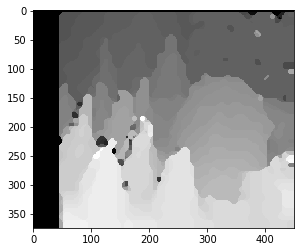

In [344]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
#from stereo_disparity_score import stereo_disparity_score
#from stereo_disparity_best import stereo_disparity_best

# Load the stereo images and ground truth.
Il = imread("../stereo/cones/cones_image_02.png", as_gray = True)
Ir = imread("../stereo/cones/cones_image_06.png", as_gray = True)

# The cones and teddy datasets have ground truth that is 'stretched'
# to fill the range of available intensities - here we divide to undo.
It = imread("../stereo/cones/cones_disp_02.png",  as_gray = True)/4.0

# Load the appropriate bounding box.
bbox = np.load("../data/cones_02_bounds.npy")

Id = stereo_disparity_fast(Il, Ir, bbox, 55)
N, rms, pbad = stereo_disparity_score(It, Id, bbox)
print("Valid pixels: %d, RMS Error: %.2f, Percentage Bad: %.2f" % (N, rms, pbad))
plt.imshow(Id, cmap = "gray")
plt.show()

In [257]:
#SOLUTION
import numpy as np
from numpy.linalg import inv
from scipy.ndimage.filters import *

def stereo_disparity_fast(Il, Ir, bbox, maxd):
    #--- FILL ME IN ---

    # Code goes here...
    window_size = 4
    assert Il.shape == Ir.shape

    # Create image arrays. Pad with 0 by window_size so the convolution
    # later doesnt go out of bounds
    # Add sobel filter to check for gradients in x and y direction
    # for calculation of SAD to improve stereo matching
    l_padded = np.pad(Il, window_size, 'edge')
    r_padded = np.pad(Ir, window_size, 'edge')
    left_imgs = [l_padded,
                 sobel(l_padded, axis=0),
                 sobel(l_padded, axis=1)]
    right_imgs = [r_padded,
                  sobel(r_padded, axis=0),
                  sobel(r_padded, axis=1)]
    Id = np.zeros_like(Il)


    # Loop through each pixel and check SAD score between the pixel and
    # others in its row from disparity = x-maxd to 0 (pixel correspondence between
    # left and right image can only be in negative direction)
    for y in range(bbox[1][0]+window_size, bbox[1][1]+window_size):
        for x in range(bbox[0][0]+window_size, bbox[0][1]+window_size):
            best_sad_score = float('inf')
            w_Il = (left_imgs[0])[y - window_size:y + window_size + 1, x - window_size:x + window_size + 1]
            ud_Il = (left_imgs[1])[y - window_size:y + window_size + 1, x - window_size:x + window_size + 1]
            lr_Il = (left_imgs[2])[y - window_size:y + window_size + 1, x - window_size:x + window_size + 1]

            for xr in range(max(x-maxd, window_size), x+1):
                # Compute SAD score
                w_Ir = (right_imgs[0])[y-window_size:y+window_size+1, xr-window_size:xr+window_size+1]
                ud_Ir = (right_imgs[1])[y-window_size:y+window_size+1, xr-window_size:xr+window_size+1]
                lr_Ir = (right_imgs[2])[y-window_size:y+window_size+1, xr-window_size:xr+window_size+1]
                sad = np.sum(np.abs(w_Il - w_Ir)) + np.sum(np.abs(ud_Il - ud_Ir)) + np.sum(np.abs(lr_Il - lr_Ir))
                # Save best SAD score and corresponding disparity
                if sad < best_sad_score:
                    best_sad_score = sad
                    Id[y-window_size][x-window_size] = x-xr
    Id = median_filter(Id, 10)


    return Id

Valid pixels: 133346, RMS Error: 3.09, Percentage Bad: 0.08


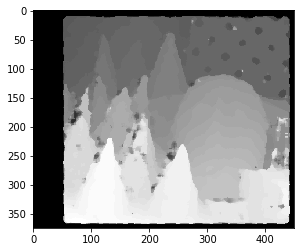

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
#from stereo_disparity_score import stereo_disparity_score
#from stereo_disparity_best import stereo_disparity_best

# Load the stereo images and ground truth.
Il = imread("../stereo/cones/cones_image_02.png", as_gray = True)
Ir = imread("../stereo/cones/cones_image_06.png", as_gray = True)

# The cones and teddy datasets have ground truth that is 'stretched'
# to fill the range of available intensities - here we divide to undo.
It = imread("../stereo/cones/cones_disp_02.png",  as_gray = True)/4.0

# Load the appropriate bounding box.
bbox = np.load("../data/cones_02_bounds.npy")

Id = stereo_disparity_fast(Il, Ir, bbox, 55)
N, rms, pbad = stereo_disparity_score(It, Id, bbox)
print("Valid pixels: %d, RMS Error: %.2f, Percentage Bad: %.2f" % (N, rms, pbad))
plt.imshow(Id, cmap = "gray")
plt.show()

31497


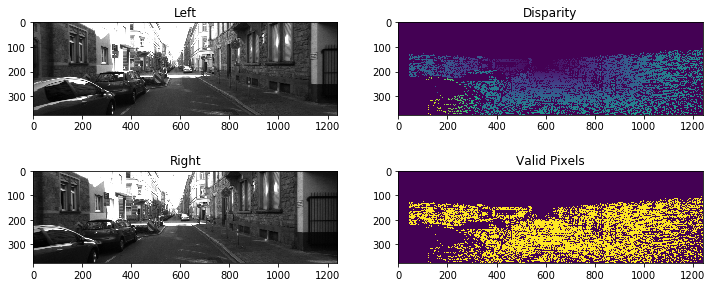

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

Il = imread('../stereo/kitti/image_0/000070_10.png')
Ir = imread('../stereo/kitti/image_1/000070_10.png')
Id = imread('../stereo/kitti/disp_noc/000070_10.png')

print(np.max(Id))

Il = np.array(Il)
Ir = np.array(Ir)
Id = np.array(Id).astype('float') / 256.0
valid = Id > 0.

f, ax = plt.subplots(2, 2, figsize=(12, 5))

ax[0][0].imshow(Il, cmap='gray')
ax[0][0].set_title('Left')

ax[1][0].imshow(Ir, cmap='gray')
ax[1][0].set_title('Right')

ax[0][1].imshow(Id)
ax[0][1].set_title('Disparity')

ax[1][1].imshow(valid)
ax[1][1].set_title('Valid Pixels')

plt.show()
